# Edge Detection

This notebook tests the edge detection algorithm.

## Principle of Edge Detection

The basic idea of edge detection using 4f imaging system is to perform a convolution with a kernel. And thus we require a algorithm for edge detection based on convolution, for which we turn to *Canny edge detector* <sup><a href=https://en.wikipedia.org/wiki/Canny_edge_detector>[1]</a></sup>. While *Canny edge detector* requires mutiple times of convolution, which has low efficieny when using a 4F imaging system, and thus we only perform the stage of *"finding the intensity gradient of the image"*. This is because that the points with large amplitude indicate a sharp change of the image intensity, which corresponds to the edge of the object.


For finding the intensity gradient of the image, we use the *Scharr operator*, which is derived from the *Sobel Operator* but maintaining good rotational symmetry <sup><a href=https://en.wikipedia.org/wiki/Sobel_operator>[2]</a></sup>.  The two kernels for the $3\times 3$ Scharr operator are,
$$
\begin{align*}
S_x=
\begin{bmatrix}
-3 & 0 & 3 \\
-10 & 0 & 10 \\
-3 & 0 & 3
\end{bmatrix}
,\;S_y=
\begin{bmatrix}
-3 & -10 & -3 \\
0 & 0 & 0 \\
3 & 10 & 3
\end{bmatrix}.
\end{align*}
$$
And then, for an image matrix denoted as $A$, the gradient can be calculated as follows,
$$
\begin{align*}
G_x(A)=S_x*A,\;G_y(A)=S_y*A,\\
G(A)=\sqrt{G_x(A)^2+G_y(A)^2},\\
\Theta_G(A)=\arctan(G_y(A)/G_x(A)).
\end{align*}
$$

However, we got a problem here. It is difficult to calculate the amplitude of the gradient from its component by using two different kernels. Even though performing two times of convolution seperately is physically possible, adding their squares together is not. Thus, we need to use a *"combination of two kernels"* to calculate the gradient. To do this, we cleverly use the property of a complex number: Encode the x component into its real part, and the y component into its imaginary part. Then, the amplitude of the gradient is simply the amplitude of the complex number.  Now, we get new and single complex *Scharr Operator* as follows,
$$
\begin{align*}
S=\begin{bmatrix}
-3-3j & -10j & 3-3j \\
-10 & 0 & 10 \\
-3+3j &10 & 3+3j
\end{bmatrix}.
\end{align*}
$$ 
Now, let's test the edge detection algorithm by simple mathematical calculation. But first, let's config the *Python* environment for the calculation.

### Import all the things

Import regular packages

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
%matplotlib inline

import cv2
from scipy import signal
import numpy as np
from cmath import pi

Add relative path

The source codes are contained in the relative path "`../scripts/`".


In [3]:
import os
currentPath=os.getcwd()
currentPath=os.path.join(currentPath,'..')
os.chdir(currentPath)

Import Diffraction Tool

The class `ImageSys4f` in `DiffractionTool.py` implement a 4f imaging system and some helper functions are defined in the class `HelperFunctions` statically.

In [4]:
from scripts.DiffractionTool import ImageSys4f
from scripts.DiffractionTool import HelperFunctions as hp

### Global Paramters

For simulation, the size of all the matrices is set to be $[N\times N]=[3001\times3001]$ with each entry of the matrices represents a pixel of size $[p\times p]=[0.3\mu m\times 0.3\mu m]$. So the total size of the image is approximately $[W\times W]=[900\mu m\times 900 \mu m]$.

In [5]:
N_size=3001
#μm plane [900,900]μm 
interval=0.3
actualSize=N_size*interval
xyInterval=[interval]*2

All the data within this notebook is contained in the relative path "`../data/`".

In [6]:
currentPath=os.getcwd()
dataPath=os.path.join(currentPath,"notebooks","data")

### Sample Image

We load a sample image of a pentagram of size $[300\mu m \times 300\mu m]$

In [7]:
filename='Prob3Data.png'
imgActualSize=300

The image is load with gray scale and then normalized.

In [8]:
grayImg=cv2.imread(os.path.join(dataPath,filename),cv2.IMREAD_GRAYSCALE)
grayImg=cv2.flip(grayImg,0)
grayImg=hp.normalize(grayImg)

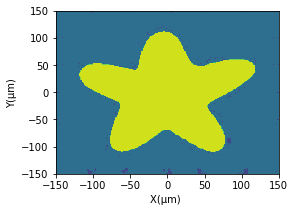

In [9]:
labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(grayImg,labels,range)

Then the image is padded into the global size of $[1000\mu m\times1000 \mu m]$ with zeros.

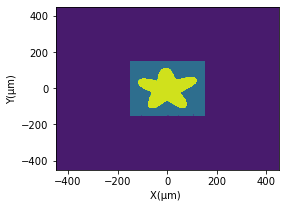

In [10]:
targetImg=hp.pad_and_resize(grayImg,imgActualSize,actualSize,N_size)
labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
hp.displace_2d(targetImg,labels,range)

### Mathematical Convolution

Now, we are ready to test the effect of the *Scharr operator* on the sample image.

#### Define a kernel

Scharr Kernel

In [11]:
edgeFilter_scharr=np.array([[ -3-3j, 0-10j,  +3 -3j],[-10+0j, 0+ 0j, +10 +0j],\
    [ -3+3j, 0+10j,  +3 +3j]])

In [12]:
print(edgeFilter_scharr)

[[ -3. -3.j   0.-10.j   3. -3.j]
 [-10. +0.j   0. +0.j  10. +0.j]
 [ -3. +3.j   0.+10.j   3. +3.j]]


The *Scharr Kernel* is also compared with the kernel given in the handouts, which I call it *Center Kernel* for the reason that it calculates the difference between the intensity of the center pixel and the intensity of the 4 surrounding pixels.

Center Kernel

In [13]:
edgeFilter_center=10*np.array([[0,-1,0],[-1,4,-1],[0,-1,0]])

In [14]:
print(edgeFilter_center)

[[  0 -10   0]
 [-10  40 -10]
 [  0 -10   0]]


#### Edge detection results

Now, let's visualize the results.

Scharr

In [15]:
resImg=signal.convolve2d(targetImg,edgeFilter_scharr,mode='same')

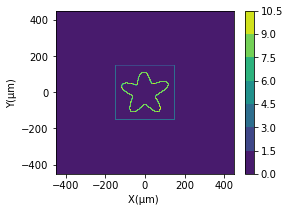

In [16]:
labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
hp.displace_2d(np.absolute(resImg),labels,range,enableColorBar=True)

Center

In [17]:
resImg=signal.convolve2d(targetImg,edgeFilter_center,mode='same')

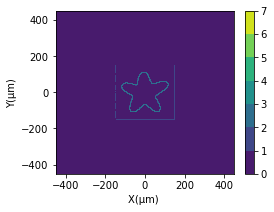

In [18]:
labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
hp.displace_2d(np.absolute(resImg),labels,range,enableColorBar=True)

Based on the above results, we find that the effect of the *Scharr Kernel* is impressive while the effect of the *Center Kernel* is slightly worse. The edge detected by the *Center Kernel* is not as clear as the edge detected by the *Scharr Kernel*. We will discuss it later in the discussion section.

## Using 4F physical imaging system

### Principle of edge detection via 4F imaging system

For the physical effects and its derivation of 4F imaging system, we refer to the textbook *Introduction to Fourier Optics*<sup><a href=https://g.co/kgs/EqKDHc>[3]</a></sup>. Here, we simply write down the results,
$$
U_f(-x,-y)=\frac{1}{j\lambda f}[U_0(x,y)*h(x,y)],
$$
where $U_f$ is the output field, $U_0$ is the input field of the 4F imaging system, $\lambda$ is the wavelength and $f$ is the focal length of the lens. It is clear that it perform a convolution operation on the input with the kernel $h(x,y)$. However, we do not directly have access to encode the kernel. What we do have access to the frequency filter $H(x',y')$, which is defined as,
$$
h(x,y)=\frac{1}{j\lambda f}\int_{-\infty}^{+\infty}\int_{-\infty}^{+\infty}H(x',y')\bullet exp\left\{-j2\pi\frac{1}{\lambda f}\left[x'x+y'y\right]\right\}dx'dy',
$$
which is literally the Fourier component of $h(x,y)$ with the frequency $f_x=\frac{x'}{\lambda f},\,f_y=\frac{y'}{\lambda f}$. While this is a little bit tricky since all our sample matrices are of the same size and the factor $\frac{1}{\lambda f}$ is difficult to be included in the standard FFT. 

**However, since reflection and rotation operations do not affect the total effect of the kernels, we can use a len to perform the convolution operation and get the distribution of $H(x',y')$ with correct physical spatial scale.** The idea is to set the field at $z=-f$ in front of the len to be $U_0(x,y)=h(x,y)$, and simply get the distribution of $H(x',y')$ at $z=f$ after the len. Remember that this is not a standard iFFT but the reflection and rotation operation does not affect the total effect of $H(x',y')$.

### Parameters Setting

For parameters of the 4f imaging system, we must be careful. Firstly, we choose the wave length of the light to be $633nm$ and we also set the radius of the lens to be $600\mu m$, recall that our sample window is $[1000\mu m\times1000 \mu m]$, this means that our lens are actually square with the side length of $1000\mu m$. And we need to determine the approximate size of the input image and the focus length.

Firstly, the above output formula is only valid when the Fresnel approximation and Paraxial approximation is valid, i.e.
$$
\begin{aligned}
Fresnel&:\,f^3\gg\frac{\rho^4}{8\lambda},\\
Paraxial&:\,f\gg\rho .
\end{aligned}
$$
But the actually the Fresnel formula is also valid for small $f$ since the high order terms contributes slightly to the integral due to fast oscillation. So what we actually need is simple $f\gg \rho$. 

However, recall that $x'=\lambda f f_x$, since our windows size is $[Np\times Np]$, we can get highest frequency catched by the frequency plane of 
$$
f_x^{max}=\frac{pN}{\lambda f}=\frac{0.473N}{f[/\mu m]}[\mu m^{-1}]
$$
And the lowest frequency due to the pixel size is
$$
f_x^{min}=\frac{p}{\lambda f}=\frac{0.47}{f[/\mu m]}[\mu m^{-1}]
$$
For performing edge detection, we are basically doing high-pass filtering and the maximum frequency of the kernel is
$$
f_k^{max}=\frac{1}{p}=\frac{1}{0.3\mu m}=3.3[\mu m^{-1}].
$$
Based on the above analysis, another limitation for $f$ if we want to capture the whole frequency component of the kernel is
$$
f\leq\frac{p^2N}{\lambda}=0.143N\mu m.
$$

Also, for the image to be displaced clearly, the number of pixels of the image should be as large as possible. For a image with actual size $W_i$, the number of pixels of the image should be
$$
[p_i\times p_i]=3.3\left[\frac{W_i}{\mu m}\times\frac{W_i}{\mu m}\right]
$$

For compromise on the above conditions, we set the image size to be between $[300\mu m\times 300\mu m]$ and $[400\mu m \times 400\mu m]$, and set the focal length to be $f=1000\mu m$. This also gives the best results for *Scharr Kernel* in practice.

In [19]:
waveLambda=0.633
f=1000
r=600
k=2.0*pi/waveLambda

Now we define a 4F imaging system based on the parameters.

In [20]:
edgeDetector=ImageSys4f(N_size,xyInterval,k,f,r)

#### Performance Test

We carry on the performance test for edge detection on the 4F imaging system based on two different kernels.

##### None filter

First, we take a look at the performance of the 4F imaging system without any filter. This tells us the imaging quality of the system.

In [21]:
U0=np.sqrt(targetImg)

In [22]:
Uen=edgeDetector.generate_image(U0)

It looks good but some tiny spots acting as noise in the middle of the image is visible.

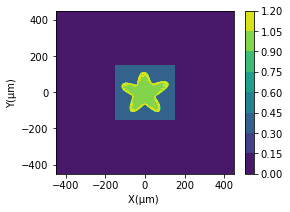

In [23]:
labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
#hp.displace_2d(np.log(hp.intensity(Ue)),labels,range,enableColorBar=True)
hp.displace_2d(np.flip(hp.intensity(Uen),(0,1)),labels,range,enableColorBar=True)

##### Scharr Filter

We calculate the Fourier component of the *Scharr kernel*  based on the method mentioned above

In [24]:
fqFilter=edgeDetector.calConvFilter(edgeFilter_scharr,1e3)

Then, such kernel is applied to the 4F imaging system.

In [25]:
Ues=edgeDetector.generate_image(U0,fqFilter)

We can conclude that the performance is quite good while the *Scharr kernel* also captures the noise spots along the edge.

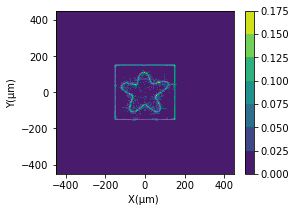

In [26]:
labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
#hp.displace_2d(np.log(hp.intensity(Ue)),labels,range,enableColorBar=True)
hp.displace_2d(np.flip(hp.intensity(Ues),(0,1)),labels,range,enableColorBar=True)

##### Center Filter

In contrast to the *Scharr kernel*, the effect of the *Center Kernel* is much more terrible. We will analyze the reason in the discussion section.

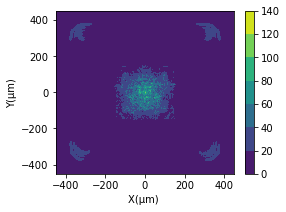

In [27]:
fqFilter=edgeDetector.calConvFilter(edgeFilter_center,1e5)
Uec=edgeDetector.generate_image(U0,fqFilter)
labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
#hp.displace_2d(np.log(hp.intensity(Ue)),labels,range,enableColorBar=True)
hp.displace_2d(np.flip(hp.intensity(Uec),(0,1)),labels,range,enableColorBar=True)

##### Zoom In

We can also take a closer look at the results.

None Filter

In [28]:
resImg=np.flip(hp.intensity(Uen),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

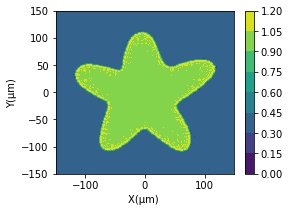

In [29]:
labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

Scharr Filter

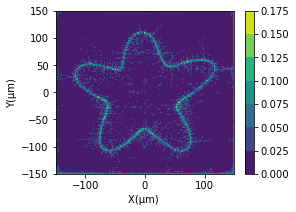

In [30]:
resImg=np.flip(hp.intensity(Ues),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

Center Filter

The effect of the *Center kernel* is terrible while we can still observe an obscure edge of the pentagram.

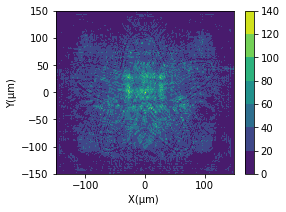

In [31]:
resImg=np.flip(hp.intensity(Uec),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

#### Play with other images

Now, we can try with other images and see the performance on more delicate images.

##### Image 1: Maki

Load the image

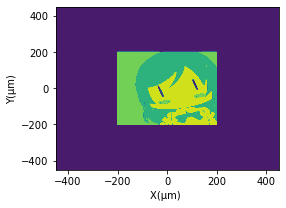

In [32]:
filename='maki.png'
imgActualSize=400

grayImg=cv2.imread(os.path.join(dataPath,filename),cv2.IMREAD_GRAYSCALE)
grayImg=cv2.flip(grayImg,0)
grayImg=hp.normalize(grayImg)
targetImg=hp.pad_and_resize(grayImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
hp.displace_2d(targetImg,labels,range)

U0=np.sqrt(targetImg)

None Filter

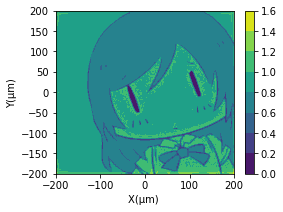

In [33]:
Uen=edgeDetector.generate_image(U0)

resImg=np.flip(hp.intensity(Uen),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

Physical Scharr Filter

It looks quite good as it capture almost all the edge.

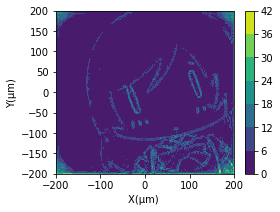

In [34]:
fqFilter=edgeDetector.calConvFilter(edgeFilter_scharr,1e4)

Ues=edgeDetector.generate_image(U0,fqFilter)

resImg=np.flip(hp.intensity(Ues),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)


Mathematical Scharr Filter

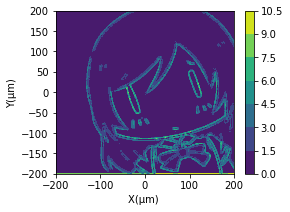

In [35]:
resImg=np.abs(signal.convolve2d(targetImg,edgeFilter_scharr,mode='same'))

zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)


##### Image 2: Pop Ko

Load the image

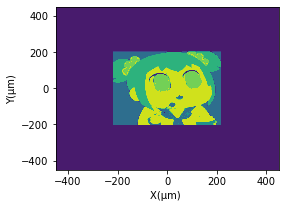

In [53]:
filename='popKo.png'
imgActualSize=400

grayImg=cv2.imread(os.path.join(dataPath,filename),cv2.IMREAD_GRAYSCALE)
grayImg=cv2.flip(grayImg,0)
grayImg=hp.normalize(grayImg)
targetImg=hp.pad_and_resize(grayImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
hp.displace_2d(targetImg,labels,range)

U0=np.sqrt(targetImg)

None Filter

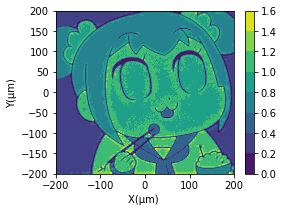

In [49]:
Uen=edgeDetector.generate_image(U0)

resImg=np.flip(hp.intensity(Uen),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

Physical Scharr Filter

The edge detection via 4F imaging system is a bit fuzzy when compared with the mathematical one.

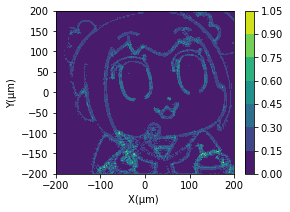

In [50]:
fqFilter=edgeDetector.calConvFilter(edgeFilter_scharr,1e3)

Ues=edgeDetector.generate_image(U0,fqFilter)

resImg=np.flip(hp.intensity(Ues),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)


Mathematical Scharr Filter

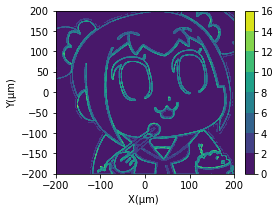

In [55]:
#resImg=np.flip(hp.intensity(Uen),(0,1))

resImg=np.abs(signal.convolve2d(targetImg,edgeFilter_scharr,mode='same'))

zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

##### Image 3: The cow

Load the image

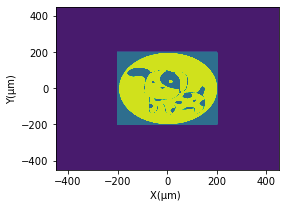

In [40]:
filename='theCow.png'
imgActualSize=400

grayImg=cv2.imread(os.path.join(dataPath,filename),cv2.IMREAD_GRAYSCALE)
grayImg=cv2.flip(grayImg,0)
grayImg=hp.normalize(grayImg)
targetImg=hp.pad_and_resize(grayImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
hp.displace_2d(targetImg,labels,range)

U0=np.sqrt(targetImg)

None Filter

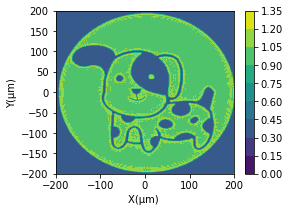

In [41]:
Uen=edgeDetector.generate_image(U0)

resImg=np.flip(hp.intensity(Uen),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

Physical Scharr Filter

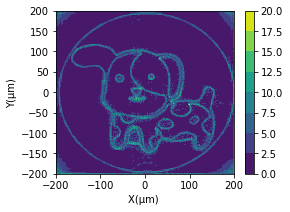

In [42]:
fqFilter=edgeDetector.calConvFilter(edgeFilter_scharr,1e4)

Ues=edgeDetector.generate_image(U0,fqFilter)

resImg=np.flip(hp.intensity(Ues),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

Mathematic Scharr Filter

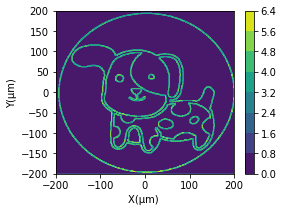

In [43]:
resImg=np.abs(signal.convolve2d(targetImg,edgeFilter_scharr,mode='same'))

zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

##### Image 4: Valve

Load the image

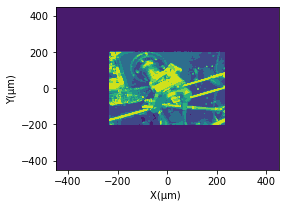

In [44]:
filename='valve.png'
imgActualSize=400

grayImg=cv2.imread(os.path.join(dataPath,filename),cv2.IMREAD_GRAYSCALE)
grayImg=cv2.flip(grayImg,0)
grayImg=hp.normalize(grayImg)
targetImg=hp.pad_and_resize(grayImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-actualSize/2.0,actualSize/2.0]]*2
hp.displace_2d(targetImg,labels,range)

U0=np.sqrt(targetImg)

None Filter

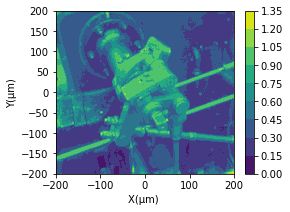

In [45]:
Uen=edgeDetector.generate_image(U0)

resImg=np.flip(hp.intensity(Uen),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

Physical Scharr Filter

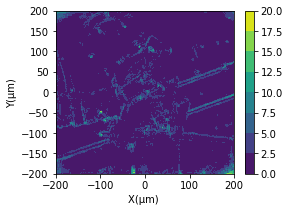

In [46]:
fqFilter=edgeDetector.calConvFilter(edgeFilter_scharr,1e4)

Ues=edgeDetector.generate_image(U0,fqFilter)

resImg=np.flip(hp.intensity(Ues),(0,1))
zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size,pad=10)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

Mathematical Scharr Filter

We see that the mathematical *Scharr kernel* tells us that the edge detection effect can be clearer. 

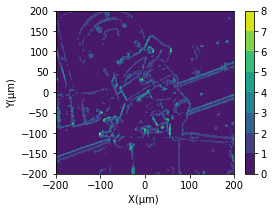

In [47]:
resImg=np.abs(signal.convolve2d(targetImg,edgeFilter_scharr,mode='same'))

zoomResImg=hp.zoom_in(resImg,imgActualSize,actualSize,N_size,pad=10)

labels=['X(μm) ','Y(μm)']
range=[[-imgActualSize/2.0,imgActualSize/2.0]]*2
hp.displace_2d(zoomResImg,labels,range,enableColorBar=True)

## Discussion and Conclusion

It is clear that the overall effects of physical 4F imaging system is not so good as its mathematical counterpart. And the *Center kernel* does not work at all when using a physical 4F imaging system. We will attribute this to the following reasons:
* *Center kernel* do not work well when the image does not have very sharp edges. As it is calculated the differences between center pixel and its surrounding pixels but not the real gradient of the image. When it comes across an image with heavy noise which results in a very blurry image, it will not be able to detect the edges.
* It is obvious that our focus length selected here does not fulfill the condition $f\leq0.143N=429 nm$. So the high frequency part of frequency domain kernel will not be captured. This results in seriously deficient of the *Center kernel*. More experiments should that smaller focus length do help improve the performance of the *Center kernel* while it makes no difference to the *Scharr kernel* but worsen the image quality as it seriously violate the condition that $f\gg\rho$.

Indeed, the condition that $f\leq0.143N$ is not fulfilled. However, another experiment which set $N=10001, r=1500\mu m$ but keep the focus length at $f=1000\mu m$ shows that the performance does not really improve for the *Scharr kernel* but do improve for the *Center kernel*. **What limits the performance of the *Scharr kernel* and why it still works under when high frequency part is discarded is still unclear**. Recall that **the lens in our simulation is actually ideal fourier len and have no aberration when $r$ is large.** I guess what limit the performance of the 4F imaging system is that the pixel size is relatively large compared with the wavelength, and the *Rayleigh speckle* limits the overall performace.

As a conclusion,